# Neurale Netzwerke - Tutorial Teil 2
---

In diesem zweiten Teil wollen wir mittels spezieller Pythonbibliotheken den Aufbau eines solchen Netzwerkes vereinfachen. Hierfür bedienen wir uns der **PyTorch**-Bibliothek (<http://pytorch.org/>)

Kurz vorweg:    
_Tieferführende Literaturvorschläge_:
* Weitere Tutorials zu PyTorch: <http://pytorch.org/tutorials/>
* Sehr gute Einführung in neuronale Netzwerke: <http://neuralnetworksanddeeplearning.com/>
* Das absolute Topbuch zu Deep Learning allgemein: <http://www.deeplearningbook.org/>

---

## 1. Installation

Die Installation sollte vergleichsweise einfach ablaufen (wenn Python 3.6, siehe Einführung in Python, über Miniconda oder Anaconda installiert wurde).
Je nach Betriebssystem müssen in der Kommandozeile innerhalb unserer virtuellen Umgebung folgende Installationsbefehle eingegeben werden:

_Installieren der relevanten Python-Bibliotheken_:   
`conda install pytorch=0.4.1 cuda80 -c pytorch`   
`conda install torchvision -c pytorch`      


Hier gehe ich davon aus das erstmal niemand direkten Zugriff auf eine Nvidia-GPU hat. Falls je, in den Kommentaren nach `[Mit GPU]` schauen.

---

## 2. Aufbau des Netzwerkes

## 2.1 FCNs

Im ersten Teil des Tutorials haben wir ein einfaches **Fully-connected Neural Network (FCN)** aufgebaut, mit 3 Schichten zu 748, 30 und 10 Neuronen. Das wollen wir mit PyTorch replizieren:

In [1]:
### PyTorch importieren
import torch

FCN = torch.nn.Sequential(
      torch.nn.Linear(784, 30), # Erste/Zweite Schicht: 784 Eingangsneuronen zu 30 "versteckten" Neuronen
      torch.nn.ReLU(),          # Aktivierungsfunktion
      torch.nn.Linear(30, 10),  # Zweite/Erste Schicht: 30 "versteckte" Neuronen gehen über zu 10 Ausgangsneuronen.
      torch.nn.Softmax(dim=1)   # Ausgangsaktivierungsfunktion. Siehe vorheriges Tutorial.
      )

print("Zusammenfassung:\n",FCN)

Zusammenfassung:
 Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=10, bias=True)
  (3): Softmax()
)


Und das wars! Das gesamte Netzwerk ist fertig aufgebaut und bereit zum Verwenden!

Zum genaueren Verständnis gehen wir aber alles noch einmal stückweise durch:
Zuerst importieren wir die PyTorch-Bibliothek mit 

`import torch`

Danach rufen wir das Submodul `nn` und dessen Unterklasse `Sequential` auf. `Sequential()` ist ein Hülle, in welche wir unsere Schichten reinstecken, die das Netzwerk ausmachen. Das kann man sich wie einen Binder vorstellen, welcher die einzelnen Papiere zusammen hält. Wir im Binder ist die Reihenfolge wichtig!

In unserem Beispiel sind die Schichten die einzelnen Neuronschichten `nn.Linear()`. 

Diese nehmen als Input die eingehenden und ausgehenden Neuronen. Wer sich im vorherigen Tutorial an die Matrizen-Notation erinnert, der weiß, dass das nötig ist, um die Transformationsmatrix zu konstruieren, die beispielsweise von der Eingangsschicht zur Versteckten transformiert.

Für die Extraportion Nichtlinearität setzen wir wie schon im vorherigen Tutorial Aktivierungsfunktionen ein (`nn.ReLU()`), sowie `nn.Softmax()` als Ausgabefunktion, damit wir Wahrscheinlichkeiten rausgegeben bekommen.

Und voilà - das Netzwerk ist komplett. Um es nun zu trainieren, müssen wir alles Drumherum wieder aufsetzen: Das Einlesen der Daten sowie die Präparation und im Anschluss noch einige Eigenheiten von PyTorch beachten.

### 2.1.1. Gesamte Trainingsstruktur

Neben dem einfachen Aufbau von Netzen bietet PyTorch zum Einlesen und Verwenden der Daten noch viele hilfreiche Mittel! Entsprechend werde ich zuerst die Struktur zeigen, dann Stück für Stück erläutern.

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

from PIL import Image

from torchvision import transforms

import os
import numpy as np

class MNIST_Data_Provider(Dataset):
    def __init__(self, all_image_paths, all_image_labels):
        super(MNIST_Data_Provider, self).__init__()
        #Dieser befehl gibt in Kurzfassung an, das Grundeinstellungen
        #aus der Vaterklasse geerbt werden sollen, in diesem Fall
        #torch.utils.data.Dataset.
        
        self.all_image_paths, self.all_image_labels = all_image_paths, all_image_labels
        # Alle Dateipfade setzen
        
        self.transform_to_torch_tensor = transforms.ToTensor()
        # PyTorch arbeitet mit Tensor-Objekten, analog wie Numpy mit
        # numpy-array Objekten arbeitet.
        
        self.hot_list = np.eye(10).astype(int)     
        
    def one_hot(self, label):
        """
        Zahl zu Vektornotation konvertieren.
        """
        return self.hot_list[label]
    
    def __getitem__(self, idx):
        loaded_image    = Image.open(self.all_image_paths[idx])
        label_for_image = self.all_image_labels[idx]
        
        return self.transform_to_torch_tensor(loaded_image), label_for_image
    
    def __len__(self):
        return len(self.all_image_paths)
    

def get_image_paths(path_to_folder):
    all_image_paths = []
    all_labels      = []
    for numberpath in os.listdir(path_to_folder):
        if numberpath != ".DS_Store":
            all_image_paths.extend([path_to_folder+"/"+numberpath+"/"+x for x in os.listdir(path_to_folder+"/"+numberpath)])
            all_labels.extend([int(numberpath) for _ in range(len(os.listdir(path_to_folder+"/"+numberpath)))])
    return all_image_paths, all_labels    

Hier erstellen wir eine Datenklasse, welche von `torch.utils.data.Dataset` erbt (die genauen Spezifikationen sind nicht so wichtig). Ihre Aufgabe ist es, `datagen()` aus dem vorherigen Tutorial zu ersetzen und uns die Bilder zurückzugeben. 
Wie das Bild zurückgegeben wird ist in der Funktion `__getitem__()` festgesetzt, welche auf Anfrage ein Trainingsbild zurückgibt.


Damit lässt sich das Training des Netzes nun wie folgt gestalten:

In [3]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from PIL import Image
import os
import sys

""" Wichtige Hyperparameter setzen """
# Hyperparameter nennt man Parameter, die 
# indirekt die Perfomance unseres Netzwerkes beeinflussen.
batch_size             = 64
n_epochs               = 10
learning_rate          = 0.003
train_validation_split = 0.8 #Prozentuale Einteilung in Trainings- und Validierungsdaten

# Pfad zum Trainingsset. In diesem Fall befindet sich dieses im gleichen Ordner wie
# das Jupyter Notebook.
path_to_MNIST_dataset = os.getcwd()+"/trainingSet"

# Wie im vorherigen Tutorial holen wir uns hier eine Liste aller Bildpfade und Labels.
all_image_paths, all_image_labels = get_image_paths(path_to_MNIST_dataset)

# Hier werden diese dann durchmischt. 
# np.random.seed() sorgt dafür, das stets die gleiche Durchmischung stattfindet.
np.random.seed(1)
np.random.shuffle(all_image_paths)
np.random.seed(1)
np.random.shuffle(all_image_labels)

#Aufteilungsindex zwischen Trainings- und Validierungsdatensatz.
split_idx = int(len(all_image_paths)*train_validation_split)

#Aufbau des Trainings-Datengenerators
training_img_paths = all_image_paths[:split_idx]
training_labels    = all_image_labels[:split_idx]
train_dataset = MNIST_Data_Provider(training_img_paths, training_labels)
train_datagen = DataLoader(train_dataset, batch_size=batch_size,drop_last=True, shuffle=True, num_workers=0)

#Aufbau des Validierungsdatengenerators
validation_img_paths = all_image_paths[split_idx:]
validation_labels    = all_image_labels[split_idx:]
val_dataset = MNIST_Data_Provider(validation_img_paths, validation_labels)
val_datagen = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=False, num_workers=0)

In [4]:
# Aufbau des Netzwerkes wie oben.
FCN = torch.nn.Sequential(
      torch.nn.Linear(784, 150), # Erste/Zweite Schicht: 784 Eingangsneuronen zu 30 "versteckten" Neuronen
      torch.nn.LeakyReLU(),          # Aktivierungsfunktion
      torch.nn.Linear(150, 30),  # Zweite/Erste Schicht: 30 "versteckte" Neuronen gehen über zu 10 Ausgangsneuronen.
      torch.nn.LeakyReLU(),          # Aktivierungsfunktion
      torch.nn.Linear(30, 10),  # Zweite/Erste Schicht: 30 "versteckte" Neuronen gehen über zu 10 Ausgangsneuronen.    
      torch.nn.Softmax(dim=1)   # Ausgangsaktivierungsfunktion. Siehe vorheriges Tutorial.
      )


#Sammler verschiedener Metriken, in diesem Fall der Trainings
#und Validierungsgenauigkeiten
data_coll = {"t_acc":[], "v_acc":[]}

Das obige Skript beinhaltet alles, was nötig ist, um ein Neuronales Netzwerk zu trainieren: WIr haben unseren Datengenerator `datagen()` (mehr dazu gleich), unser **FCN**, eine Kostenfunktion `F.cross_entropy()`(siehe vorheriges Tutorial) sowie als Optimierungsalgorithmus einen Standard-Gradientenminimierer, `optim.SGD()`, wobei _SGD_ kurz für _Stochastic Gradient Descent_ ist.

**Dataloader**
Der `Dataloader` selbst ist eine Hülle für unser `Dataset` welches wir weiteroben geschrieben haben. Die Aufgabe hier ist es einfach, das Rausziehen der Daten zu vereinfachen und zu parallelisieren. Die Parameter, die man ihm übergibt, sind dabei die `batch_size`, d.h. für wie viele Bilder der Gradient berechnet werden soll, bis die Netzwerkgewichte upgedatet werden, `num_workers`, welches der Anzahl der CPU-Kernen entspricht sowie `shuffle` und `remove_last`, welches für Durchmischen der Daten und entfernen von Batches sind, die nicht `batch_size` entsprechen.

**Optimierer**
Als Optimierer haben wir hier einen _Stochastic Gradient Descent_-Algorithmus verwendet, welcher auch im vorherigen Tutorial zu finden ist. Alternativen, die zum Teil wesentlich besser funktionieren, finden sich unter <http://pytorch.org/docs/master/nn.html#loss-functions>.
Eine genauere Betrachtung verschiedener Optimierer werden wir, wenn die Zeit da ist, noch durchgehen. Ansonsten einfach ausprobieren!

Generell lassen sich diese aber in zwei Klassen einteilen: Adaptive und Nicht-adaptive Methoden, welche sich darin unterscheiden, ob die Lernrate angepasst (_adaptiv_) oder belassen wird.

In die zweite Kategorie fallen Methoden wie `SGD`, `SGD mit Impuls` oder `Adadelta`, wobei letztere Methoden eine zerfallende Summe vergangener Gradienten sammeln, um schneller konvergieren zu können und Sattelpunkten bzw. kleineren lokalen Minima entkommen können:

Erinnern wir uns an die Vorschrift für `SGD`:

-  Für die Gewichte: 
\begin{equation}
w_{ik}^{j(t+1)} = w_{ik}^{jt} - \frac{\eta}{bs} \sum_{s=1}^{bs}\frac{\partial L(\textbf{o}_s,\textbf{t}_s)}{\partial w_{ik}^{jt}}
\end{equation}
-  Für die Offsets:
\begin{equation}
b_{i}^{j(t+1)} = b_{i}^{jt} - \frac{\eta}{bs} \sum_{s=1}^{bs}\frac{\partial L(\textbf{o}_s,\textbf{t}_s)}{\partial b_{i}^{jt}}
\end{equation}

so sieht beispielsweise `SGD mit Impuls`, oder auch `SGD with Momentum` so aus (gezeigt anhand der Gewichte):

\begin{equation}
w_{ik}^{j(t+1)} = w_{ik}^{jt} - \eta \cdot \nu^{jt}_{ik}
\end{equation}

wobei 

\begin{equation}
\nu^{jt}_{ik} = \gamma \cdot \nu^{j(t-1)}_{ik} + \frac{1}{bs} \sum_{s=1}^{bs}\frac{\partial L(\textbf{o}_s,\textbf{t}_s)}{\partial w_{ik}^{jt}}
\end{equation}

Der Parameter $\gamma\in [0,1]$ wird als "Reibung" bezeichnet, da er die momentane Summe der Gradienten, analog zu einer Geschwindigkeit reduziert. Wohlgemerkt für $\gamma=0$ haben wir einfach `SGD`.

Adaptive Methoden verwenden ähnliche Kollektionen, d.h. zerfallende Summen der Gradienten im ersten und/oder zweiten Momenten, um die Lernrate in sinnvolle Richtungen zu lenken.

Darunter fallen beispielsweise `Adam`, `RMSPROP` oder `Nadam`.
Für mehr Info, siehe neben der offiziellen PyTorch Dokumentation, zum Beispiel http://ruder.io/optimizing-gradient-descent/.

---

Andere wichtige **Schlüsselwörter** sind im Code selbst erklärt!


In [5]:
#Start des eigentlichen Trainings.
device = torch.device('cpu')
# ### Wenn eine GPU verwendet wird, einfach diese Zeile ausklammern:
# device = torch.device('cuda')
_ = FCN.to(device)

#Optimierungsalgorithmus - Er nimmt die Lernrate und die Netzwerkparameter und updated diese je
#nach Gradienten. Diese wird später im Traininglauf berechnet (unten).
optimizer = optim.Adam(FCN.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    print("Training in Epoch {}...".format(epoch))
    
    """ Hier startet das Training! """
    FCN.train() #Schlüsselwort um das Netz in Trainingsmodus zu stecken.
                #Hier für uns nicht direkt wichtig, aber einige besondere Netzwerkschichten
                #verhalten sich während Training und Validierung unterschiedlich
    
    train_avg_loss = 0
    train_avg_acc  = 0
    
    for idx, (img,label) in enumerate(train_datagen):
        
        # Unser Datengenerator gibt uns Bilder und Labels aus.
        # Diese müssen wir für PyTorch in Objekte umwandeln, für die
        # mathematisch ein Gradient berechnet werden kann. 
        # Ausserdem schieben wir unser Objekt nach <device>.
        # Dies ist relevant, falls <device> eine GPU bei uns stellt.
        img, label = img.to(device), label.to(device)

        # Die Vorhersage unseres Netzwerkes für ein Satz Bilddaten, welche vorher zu Form
        # (Batch_size, n_classes) vektorisiert wird.
        output = FCN(img.view(batch_size,-1))
        
        # Unsere Kostenfunktion, Categorical Cross-Entropy.
        loss = F.cross_entropy(output, label)

                
        # Hier setzen wir vormals berechnete Gradienten of 0.
        optimizer.zero_grad()
        # Dann berechnen wir diese erneut abhängig zur Kostenfunktion.
        loss.backward()
        # Im Anschluss werden alle Gewichte upgedatet.
        optimizer.step()
        
        # Anzahl an korrekt vorhergesagter Bilder.
        # Erklärung des Kettenbegriffs:
        # Mit Variable()-Objekten kann nicht gut direkt gearbeitet werden. Daher nehmen wir uns deren
        # Zahleninhalt mit .data, suchen das entsprechende Maximum entlang der 1. Achse und vergleichen das
        # elementweise mit dem wahren Wert über .eq(label.data). Im Anschluss wird das Ergebnis aufsummiert und gibt
        # die Anzahl korrekter Vorhersagen pro Batch zurück.
        correct_guesses = output.cpu().detach().max(1)[1].eq(label.cpu().detach()).sum()
        
        # Hier sammeln wir Kosten und Genauigkeit während dem Training.
        train_avg_loss += loss.item()
        train_avg_acc  += correct_guesses.numpy()
        
        if idx%300==0 and idx!=0:
            print("\t T-Progress: [{}/{}]\r".format(idx+1,len(train_datagen)))

    # Um prozentuale Ergebnisse zu bekommen, mitteln wir alles durch die Anzahl an Trainingsbildern.
    train_avg_loss = train_avg_loss*1./(batch_size*len(train_datagen))
    train_avg_acc  = train_avg_acc*1./(batch_size*len(train_datagen))
    
    data_coll["t_acc"].append(train_avg_acc)
    """ Hier startet die Validierung """
    FCN.eval() #Netzwerk wird in Validierungs-/Testmodus gesteckt.
    
    ### Ab hier das gleiche Prozeder wie während dem Training, lediglich ohne 
    ### Trainieren der Parameter.
    val_avg_acc = 0
    
    with torch.no_grad():
        for idx, (img,label) in enumerate(val_datagen):
            img, label = img.to(device), label.to(device)
            output     = FCN(img.view(batch_size,-1))
            correct_guesses = output.cpu().detach().max(1)[1].eq(label.cpu().detach()).sum()

            val_avg_acc  += correct_guesses.numpy()

            if idx%100==0 and idx!=0:
                print("\t V-Progress: [{}/{}]\r".format(idx+1,len(val_datagen)))    

    val_avg_acc = val_avg_acc*1./(batch_size*len(val_datagen))
    data_coll["v_acc"].append(val_avg_acc)
    print("Results: T-Loss {0:2.5f} | T-Acc {1:3.4f}% | V-Acc {2:3.4f}%".format(train_avg_loss, train_avg_acc*100., val_avg_acc*100.))

Training in Epoch 0...
	 T-Progress: [301/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02564 | T-Acc 83.2083% | V-Acc 93.0582%
Training in Epoch 1...
	 T-Progress: [301/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02380 | T-Acc 94.0774% | V-Acc 94.1198%
Training in Epoch 2...
	 T-Progress: [301/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02360 | T-Acc 95.1667% | V-Acc 95.2409%
Training in Epoch 3...
	 T-Progress: [301/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02349 | T-Acc 95.8869% | V-Acc 94.9905%
Training in Epoch 4...
	 T-Progress: [301/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02342 | T-Acc 96.2917% | V-Acc 94.6565%
Training in Epoch 5...
	 T-Progress: [301/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02337 | T-Acc 96.5833% | V-Acc 95.5153%
Training in Epoch 6...
	 T-Progress: [301/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02332 | T-Acc 96.8363% | V-Acc 95.9924%
Training in Epoch 7...
	 T-Progress: [301/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02326 | 

---

### 2.1.2. Aufgaben

#### 1. Aufgabe

Geht durch die Beschreibungen auf <http://pytorch.org/docs/master/nn.html> und schaut, ob ihr Änderungen findet, die das Netz evtl. besser trainieren lassen!

#### 2. Aufgabe 

Nehmt einen Trainingsdurchgang auf und plottet Kosten/Genauigkeit gegen Epoche oder Iteration!

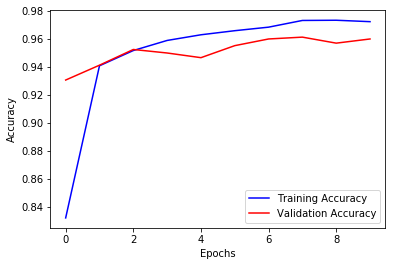

In [7]:
import matplotlib.pyplot as plt

plt.plot(data_coll["t_acc"],"b",label='Training Accuracy')
plt.plot(data_coll["v_acc"],"r",label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

---

## 2.2 Convolutional Neural Networks (CNNs)

Bis hierhin haben wir uns mit **FCN**s auseinandergesetzt, welche versuchen (zumindest in stark vereinfachenden Zügen) das Gehirn und seine Neuronen nachzustellen. Eine zweite Klasse, die solche Netzwerke aus einem rein mathematischen Standpunkt angeht, sind sog. **Convolutional Neural Network**s **(CNN)**s.

Anders als bei unseren FCNs haben wir es hier mit **Filtern** statt Neuronen zu tun. Zudem nehmen sie als Eingangssignal direkt Bilder oder andere volumetrische Daten. Die Grobstruktur sieht aus wie in der unteren Abbildung (Quelle: >https://www.kdnuggets.com/2015/11/understanding-convolutional-neural-networks-nlp.html>).

<img src="Bilder/cnn.png"> 

Eine ergänzende Darstellung (entnommen von <https://stackoverflow.com/questions/42733971/convolutional-layer-to-fully-connected-layer-in-cnn>) findet sich ebenso:

<img src="Bilder/cnn2.png">

Beide Bilder (ansonsten einfach das Internet nach Bildern durchforsten) reichen hoffentlich aus, um die Wirkungsweise solche Netzwerke klarzustellen.

Wir starten mit unserem Bild (in unserem Fall das Bild einer Zahl) und füttern es in ein **CNN**. Dieses hat, ähnlich wie das **FCN**, eine Reihe von Schichten:


### 2.2.1 Convolutional Layer

Das ist die Hauptschicht (ähnlich den Neuronen im FCN). Eine Hauptschicht ist eine Ansammlung sog. Filter, kleine Matrizen mit Gewichten, welche jeweils über das Bild geschoben werden und eine Convolution/Faltung berechnen (mathematisch eigentlich eine Korrelation, aber das tut nichts zur Sache). Das sieht etwa so aus:

<img src="Bilder/conv_pic_example.png">

Wie man erkennen kann, nimmt ein Filter eine Pixelgruppe und gewichtet die Werte zu *einem* Aktivierungswert. Macht er das für alle Pixelgruppen auf einem Bild, entsteht eine sog. **Feature map** - eine Abbildung des Bildes zu einem Bild welches besondere Bildeigenschaften hervorhebt, z.B. Kanten.

Da sich in jeder Schicht mehrere solcher Filter befinden, gibt es auch entsprechend viele solcher **Feature maps**. In obigen Bild ist dies durch die Breite (_96, 256, ..._) angegeben, da am Ende einer Schicht alle dieser feature maps verkettet werden, denn:

In der nächsten Schicht nehmen sich die Filter wieder Pixelgruppen vor, dieses mal aber für alle Pixel in allen feature maps innerhalb einer Gruppenposition.

**Ein Beispiel:**
Seien in der ersten Schicht 20 Filter vorhanden. Das Eingangsbild hat die Maße $224\times 224$. Die Filter haben je die Größe $3\times3$. Nach Anwenden verbleiben wir mit 20 $222\times222$-Bildern (die reduzierte Größe liegt daran, das an den Bildkanten der Filter etwas verschoben werden muss und so die Randpixel nicht gleich oft wie innere Pixel erfasst werden). Nach Verkettung macht das einen $20\times222\times222$-Klotz.
In der nächsten Schicht haben dann die Filter die Ausmaße $20\times3\times3$, da die Informationen aus **allen** feature maps zusammengeführt werden!

**Anmerkung**: Um die Bildverkleinerung zu bekämpfen, kann man stets das Eingangsbild/die Eingangsfeaturemaps an den Seiten mit Nullen ausstatten, und die Größe vor den Berechnungen etwas erhöhen, sodas am Ende wieder die gleiche Größe herauskommt.


### 2.2.2 Pooling Layer

Um die Anzahl an Gewichten zu reduzieren, führt man ganz gerne **Pooling Layer** ein. Das sind Minischichten, deren einzige Aufgabe es ist, die Ausmaße des Netzes zu reduzieren. Sie definieren sich über eine **Kerngröße/Kernelsize** ähnlich den Filtern oben. Sie nehmen sich eine Pixelgruppe vor und führen eine Operation aus, z.B. den Maximalwert oder das arithmetische Mittel nehmen. Entsprechend nennt man solche Schichten auch **Maxpooling**- bzw. **Averagepooling**-**Layer**.

**Ein Beispiel**:
Ein Satz Featuremaps der Größe $20\times200\times200$ hat nach einem *Maxpoolinglayer* mit *Kernelsize* $2\times2$ die Größe $20\times100\times100$.

### 2.2.3 Sonstige Schichten

Ansonsten sind die restlichen Schichten sehr ähnlich zu denen in einem **FCN**, d.h. eine Schicht mit einer Aktivierungsfunktion und/oder andere Funktionen.

Zudem ist es nicht unüblich, das **CNN** mit einem kleinen **FCN** abzuschließen. Hierfür werden die letzten Featuremaps entsprechend vektorisiert (d.h. bei einem finalen Featureklotz der Größe $20\times15\times15$ wird ein Vektor der Länge $4500$ ausgespuckt) und in ein **FCN** gesteckt.

Das ist auch in den obigen Bildern zu sehen.

## 2.3 Implementierung

Nun wollen wir uns wieder an die Implementierung machen und schauen, wie sich diese Netzwerkstruktur im Vergleich zu einem **FCN** schlägt. Natürlich verwenden wir wieder PyTorch. 


### 2.3.1 Für das Netzwerk:

Intuitiv würde man meinen, dass man die Notation von oben verwenden, um das Netz zu implementieren, d.h etwas in diser Richtung:

In [29]:
import torch.nn as nn

CNN = torch.nn.Sequential(
        nn.Conv2d(1,10, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Conv2d(10,20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d((2,2)), #Hier fehlt der Übergang von Bild- zu Vektorstruktur    
        nn.Linear(320,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.Softmax(dim=1)
      )

Allerdings kann so nur umständlich der Übergang von Bild- zu Vektorstruktur erreicht werden

Daher werden wir hier noch eine andere PyTorch-Notation einführen, mit der man kompliziertere Netze aufbauen kann:

In [30]:
import torch.nn as nn

class CNN_Base(nn.Module):
    def __init__(self):
        super(CNN_Base,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)  # 26x26
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3) # 24x24
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3,padding=1)  # 12x12
        self.conv4 = nn.Conv2d(30, 30, kernel_size=3,padding=1)  # 12x12
        self.conv5 = nn.Conv2d(30, 50, kernel_size=3,padding=1) # 6x6        
        self.conv6 = nn.Conv2d(50, 50, kernel_size=3,padding=1)# 6x6                
        self.fc1 = nn.Linear(1800, 150)
        self.fc2 = nn.Linear(150, 50)
        self.fc3 = nn.Linear(50, 10)
        self.out_act = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv2(self.conv1(x)), 2))
        x = F.leaky_relu(F.max_pool2d(self.conv4(self.conv3(x)), 2))
        x = F.leaky_relu(self.conv6(self.conv5(x)), 2)
        x = x.view(-1, 1800)   #Hier ändern wir Bild- zu Vektorformat
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))        
        x = self.fc3(x)
        return self.out_act(x)
    

Hier ist alles aufgeteilt in zwei Teile:
Innerhalb der `__init__()`-Funktion werden alle Netzschichten initialisiert, die Gewichte besitzen (d.h. mit zufälligen Gewichten ausgestattet, ähnlich einen Lexikon verfügbarer Bauklötze.

Die tatsächliche Verknüpfung findet dann in `forward()` statt, d.h. hier wird dann mit den im Lexikon zu findenden Bauklötzen das eigentliche Netzwerk aufgebaut.

Das erlaubt es, sehr komplizierte Strukturen zu implementieren. Die Funktionsweise und die Verwendung im allgemeinen Programm bleibt aber die Gleiche.

### 2.3.2 Für das allgemeine Training

Da wir nur das Netzwerk abgeändert haben, können wir einfach die **FCN**-Trainingsstruktur kopieren und einfach unser neues Netzwerk einfügen. Die einzigen Änderungen die zu beachten sind ist die Tatsache, dass die Bilder nun nicht mehr Vektoren, sondern einfach Bilder sind. Dafür müssen wir aber lediglich die `img.view(batch_size,-1)`-Zeile entfernen:

In [37]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from PIL import Image
import os
import sys

""" Hyperparameter """
batch_size = 64
n_epochs   = 20
learning_rate = 0.0003
train_validation_split = 0.8

""" Aufsetzen der Datengeneratoren """
path_to_MNIST_dataset = os.getcwd()+"/MNIST/trainingSet"

all_image_paths, all_image_labels = get_image_paths(path_to_MNIST_dataset)

np.random.seed(1)
np.random.shuffle(all_image_paths)
np.random.seed(1)
np.random.shuffle(all_image_labels)

split_idx = int(len(all_image_paths)*train_validation_split)

training_img_paths = all_image_paths[:split_idx]
training_labels    = all_image_labels[:split_idx]
train_dataset = MNIST_Data_Provider(training_img_paths, training_labels)
train_datagen = DataLoader(train_dataset, batch_size=batch_size,drop_last=True, shuffle=True, num_workers=1)

validation_img_paths = all_image_paths[split_idx:]
validation_labels    = all_image_labels[split_idx:]
val_dataset = MNIST_Data_Provider(validation_img_paths, validation_labels)
val_datagen = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=False, num_workers=1)

In [38]:
""" Laden des Netzes, Aufsetzen des Optimierers"""
CNN = CNN_Base()
device = torch.device('cpu')
# ### Falls eine GPU verwendet wird:
# device = torch.device('cuda')
_ = CNN.to(device)
#optimizer = optim.SGD(FCN.parameters(), lr=learning_rate)
optimizer = optim.Adam(CNN.parameters(), lr=learning_rate)


""" Training & Validierung """
for epoch in range(n_epochs):
    print("Training in Epoch {}...".format(epoch))
    
    """ Hier startet das Training! """
    #FCN.train()
    CNN.train()
    
    train_avg_loss = 0
    train_avg_acc  = 0
    
    data_coll = {"t_acc":[], "v_acc":[]}
    for idx, (img,label) in enumerate(train_datagen):
        img, label = img.to(device), label.to(device)
        
        optimizer.zero_grad()
        #output = FCN(img.view(batch_size,-1))
        output = CNN(img)
        
        loss = F.cross_entropy(output, label)
        
        loss.backward()
        optimizer.step()
        
        correct_guesses = output.cpu().detach().max(1)[1].eq(label.cpu().detach()).sum()
        
        train_avg_loss += loss.data.item()
        train_avg_acc  += correct_guesses.numpy()
        
        if idx%100==0 and idx!=0:
            print("\t T-Progress: [{}/{}]\r".format(idx+1,len(train_datagen)))

    train_avg_loss = train_avg_loss*1./(batch_size*len(train_datagen))
    train_avg_acc  = train_avg_acc*1./(batch_size*len(train_datagen))
    
    data_coll["t_acc"].append(train_avg_acc)
    
    
    """ Hier startet die Validierung """
    #FCN.eval()
    CNN.eval()
    
    with torch.no_grad():
        val_avg_acc = 0

        for idx, (img,label) in enumerate(val_datagen):
            img, label = img.to(device), label.to(device)
            #output = FCN(img.view(batch_size,-1))
            output = CNN(img)
            correct_guesses = output.cpu().detach().max(1)[1].eq(label.cpu().detach()).sum()

            val_avg_acc  += correct_guesses.numpy()

            if idx%100==0 and idx!=0:
                print("\t V-Progress: [{}/{}]\r".format(idx+1,len(val_datagen)))    

        val_avg_acc = val_avg_acc*1./(batch_size*len(val_datagen))
        data_coll["v_acc"].append(val_avg_acc)    
        print("Results: T-Loss {0:2.5f} | T-Acc {1:3.4f}% | V-Acc {2:3.4f}%".format(train_avg_loss, train_avg_acc*100., val_avg_acc*100.))

Training in Epoch 0...
	 T-Progress: [101/525]
	 T-Progress: [201/525]
	 T-Progress: [301/525]
	 T-Progress: [401/525]
	 T-Progress: [501/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02719 | T-Acc 72.2232% | V-Acc 82.9676%
Training in Epoch 1...
	 T-Progress: [101/525]
	 T-Progress: [201/525]
	 T-Progress: [301/525]
	 T-Progress: [401/525]
	 T-Progress: [501/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02491 | T-Acc 86.6905% | V-Acc 94.0840%
Training in Epoch 2...
	 T-Progress: [101/525]
	 T-Progress: [201/525]
	 T-Progress: [301/525]
	 T-Progress: [401/525]
	 T-Progress: [501/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02357 | T-Acc 95.2738% | V-Acc 96.1594%
Training in Epoch 3...
	 T-Progress: [101/525]
	 T-Progress: [201/525]
	 T-Progress: [301/525]
	 T-Progress: [401/525]
	 T-Progress: [501/525]
	 V-Progress: [101/131]
Results: T-Loss 0.02340 | T-Acc 96.3661% | V-Acc 96.9704%
Training in Epoch 4...
	 T-Progress: [101/525]
	 T-Progress: [201/525]
	 T-Progress: [301/525]
	 T-P

Process Process-37:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/karsten_dl/software/miniconda3/envs/D4L/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/karsten_dl/software/miniconda3/envs/D4L/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/home/karsten_dl/software/miniconda3/envs/D4L/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/karsten_dl/software/miniconda3/envs/D4L/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-7-eddb99f54dee>", line 38, in __getitem__
    loaded_image    = Image.open(self.all_image_paths[idx])
  File "/home/karsten_dl/software/miniconda3/envs/D4L/lib/python3.6/site-packages/PIL/Image.py", line 2618, in open
    prefix = fp.read(16)


Damit haben wir nun ein weiteres Werkzeug eingeführt, um Bilderkennung zu implementieren.

Generell ist es so, dass Netzwerk-Strukturen je nach Bedarf und Zweck entsprechend abgeändert werden. Generell gilt aber: Je tiefer das Netzwerk, desto ausdrucksstärker ist es, aber desto länger, komplizierter und anspruchsvoller ist es, dieses zu sinnvollen Werten trainiert zu bekommen.

---

### 2.3.3 Aufgaben

#### 1. Aufgabe

Visualisier auch hier das Trainingverhalten. Vergleiche dies mit der **FCN**-Struktur von oben. Idealerweise werden beide Trainingskurven in ein Diagramm geplottet!

#### 2. Aufgabe

Ändere etwas an der Struktur oder dem Optimierungsalgorithmus ab um höhere Ergebnisse erzielt zu bekommen. Wie immer ist die PyTorch-Homepage dein Freund!

#### 3. Aufgabe

Vergleiche die Anzahl der Paramter zwischen **FCN** und **CNN**. Verwende dazu folgenden Funktion:

In [20]:
def find_num_parameters(net):
    net_parameters = filter(lambda p: p.requires_grad, net.parameters())
    num_params = sum([np.prod(p.size()) for p in net_parameters])
    return num_params

---

**Damit haben wie die Grundlagen zu neuronalen Netzen abgeschlossen!**

Im nächsten Einführungsteil wollen wir uns noch mit Methoden auseinandersetzen, die das Generalisierungsverhalten und das allgemeine Training zu verbessern. Darauffolgend implementieren wir ein Netzwerk um Leber aus CT-Bildern zu segmentieren!